In [ ]:
from google.colab import files
import os
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition                                             #loading the data from the kaggle repository

-rw-r--r-- 1 root root 67 Aug 21 07:52 kaggle.json
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 38.7MB/s]
100% 270M/271M [00:02<00:00, 103MB/s]
100% 271M/271M [00:02<00:00, 101MB/s]
 99% 540M/544M [00:05<00:00, 135MB/s]
100% 544M/544M [00:05<00:00, 110MB/s]


In [ ]:
!unzip train.zip
!unzip test.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/55.jpg             
  inflating: test/550.jpg            
  inflating: test/5500.jpg           
  inflating: test/5501.jpg           
  inflating: test/5502.jpg           
  inflating: test/5503.jpg           
  inflating: test/5504.jpg           
  inflating: test/5505.jpg           
  inflating: test/5506.jpg           
  inflating: test/5507.jpg           
  inflating: test/5508.jpg           
  inflating: test/5509.jpg           
  inflating: test/551.jpg            
  inflating: test/5510.jpg           
  inflating: test/5511.jpg           
  inflating: test/5512.jpg           
  inflating: test/5513.jpg           
  inflating: test/5514.jpg           
  inflating: test/5515.jpg           
  inflating: test/5516.jpg           
  inflating: test/5517.jpg           
  inflating: test/5518.jpg           
  inflating: test/5519.jpg           
  inflating: test/552.jpg            
  inflating: test/5520.jpg           

In [ ]:
from PIL import Image
import numpy as np
TRAIN_DIR = 'train/'
TEST_DIR = 'test/'

ROWS = 64
COLS = 64
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]                                                                         # full dataset stored in this folder
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]                                                           # seperate folders for dogs and cats
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]                                                                           # test images
lol = np.array(Image.open(train_dogs[0]))
print(lol.shape)

(499, 375, 3)


In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import image
import matplotlib.pyplot as plt
dog_data = np.zeros((len(train_dogs),64,64,3))
for i in range(len(train_dogs)):                                                                                                    # resizing the dog images to 64 x 64 size for easier storage and training
  lt = Image.open(train_dogs[i])
  lt = lt.resize((64,64)) 
  x = np.array(lt)
  dog_data[i] = x

In [ ]:
cat_data = np.zeros((len(train_cats),64,64,3))                                                                                      # doing the same for cat images
for i in range(len(train_cats)):
  lt = Image.open(train_cats[i])
  lt = lt.resize((64,64))
  x = np.array(lt)
  cat_data[i] = x

In [ ]:
Y = np.zeros((25000,1))                                 
for i in range(12500):
  Y[i][0] = 1                                                                                                                       # assigning zero for dogs and one for cats
print(Y)

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]



In [ ]:
X = np.concatenate((cat_data,dog_data))                                                                                             # concatenating the dog and cat image arrays to obtain entire training data
print(X.shape)
print(dog_data.shape)

(25000, 64, 64, 3)
(12500, 64, 64, 3)


[1.]


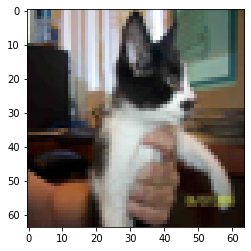

In [ ]:
plt.imshow(X[12499].astype('uint8'))
print(Y[12499])

In [ ]:
X_train = X/255.
print(X_train.shape)
print(Y.shape)

(25000, 64, 64, 3)
(25000, 1)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from keras import layers
from keras.layers import Conv2D,Add,BatchNormalization,MaxPooling2D,AveragePooling2D,Flatten,Dense,Input,Activation,ZeroPadding2D
from keras.models import Model,load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform

In [ ]:
def convolutional_block(X,f,filters,stage,block,s = 2):                                                                                                 # defining a convolutional block 
  conv_name_base = 'res' + str(stage) + block + '_branch'                                                                                               # Uses residual networks concept to carry over the image array data through layers
  bn_name_base = 'bn' + str(stage) + block + '_branch'                                                                                                  # inspiration for these blocks from the Deep Learning CNN course on Coursera

  X_shortcut = X

  F1,F2,F3 = filters

  X = Conv2D(F1,(1,1),strides = (s,s),name = conv_name_base + '2a',kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3,name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)

  X = Conv2D(F2,(f,f),strides = (1,1),padding = 'same',name = conv_name_base + '2b',kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3,name = bn_name_base + '2b')(X)
  X = Activation('relu')(X)

  X = Conv2D(F3,(1,1),strides = (1,1),name = conv_name_base + '2c',kernel_initializer = glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3,name = bn_name_base + '2c')(X)

  X_shortcut = Conv2D(F3,(1,1),strides = (s,s),padding = 'valid',name = conv_name_base + '1',kernel_initializer = glorot_uniform(seed = 0))(X_shortcut)
  X_shortcut = BatchNormalization(axis = 3,name = bn_name_base + '1')(X_shortcut)

  X = Add()([X,X_shortcut])
  X = Activation('relu')(X)

  return X

def identity_block(X,f,filters,stage,block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    
    X_shortcut = X


    X = Conv2D(F1, kernel_size = (1, 1), strides = (1,1),padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2, (f,f),strides = (1,1),padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1,1),strides = (1,1), padding = 'valid', name = conv_name_base + '2c',kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3,name = bn_name_base + '2c')(X)

    #X_shortcut = Conv2D(F3,(1,1),strides = (s,s),padding = 'valid',name = conv_name_base + '1',kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    #X_shortcut = BatchNormalization(axis = 3,name = bn_name_base + '1')(X_shortcut)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    return X

def NN(input_shape = (64, 64, 3)):
    X_input = Input(input_shape)

    
    X = ZeroPadding2D((3, 3))(X_input)
    print(X.shape)
    X = Conv2D(64, (7, 7), strides = (2, 2),padding = 'valid', name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    print(X.shape)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    print(X.shape)
    
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    print(X.shape)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    print(X.shape)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    print(X.shape)
    X = convolutional_block(X, f = 3, filters = [256,256,1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256,256,1024], stage=4, block='b')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='c')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='d')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='e')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='f')

    print(X.shape)
    X = convolutional_block(X, f = 3, filters = [512,512,2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512,512,2048], stage=5, block='b')
    X = identity_block(X, 3, [512,512,2048], stage=5, block='c')

    print(X.shape)
    X = AveragePooling2D(pool_size = (2,2))(X)
    
    print(X.shape)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc', kernel_initializer = glorot_uniform(seed=0))(X)
    print(X.shape)
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    return model


In [ ]:
m = X_train.shape[0]
Y_new = Y.T
print(m)
permutation = list(np.random.permutation(m))
shuffled_X = X_train[permutation,:]
shuffled_Y = Y[permutation,:]
print(shuffled_X.shape)
print(shuffled_Y.shape)

25000
(25000, 64, 64, 3)
(25000, 1)


[0.]


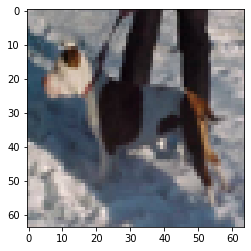

In [ ]:
plt.imshow(shuffled_X[3])
print(shuffled_Y[3])

In [ ]:
model = NN(input_shape=(64,64,3))

(None, 70, 70, 3)
(None, 32, 32, 64)
(None, 15, 15, 64)
(None, 15, 15, 256)
(None, 15, 15, 256)
(None, 8, 8, 512)
(None, 4, 4, 1024)
(None, 2, 2, 2048)
(None, 1, 1, 2048)
(None, 1)


In [ ]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [ ]:
model.fit(shuffled_X,shuffled_Y,epochs = 5,batch_size = 64)                                                                     # training the model for 5 epochs repeatedly, not all at once to avoid RAM overload on Colab 

Epoch 1/5
391/391 [==============================] - 1584s 4s/step - loss: 0.1697 - accuracy: 0.9297
Epoch 2/5
391/391 [==============================] - 1582s 4s/step - loss: 0.1517 - accuracy: 0.9370
Epoch 3/5
391/391 [==============================] - 1589s 4s/step - loss: 0.1338 - accuracy: 0.9446
Epoch 4/5
391/391 [==============================] - 1588s 4s/step - loss: 0.1166 - accuracy: 0.9543
Epoch 5/5
391/391 [==============================] - 1589s 4s/step - loss: 0.1033 - accuracy: 0.9584


In [ ]:
model.save_weights('modl.h5')                                                                                                   # saving the model weights to avoid retraining and resource wastage
files.download('modl.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_data = np.zeros((len(train_cats),64,64,3))
for i in range(len(test_images)):
  lt = Image.open(test_images[i])
  lt = lt.resize((64,64))
  x = np.array(lt)
  test_data[i] = x
test_data = test_data/255.
print(test_data.shape)
#test_flat = test_data.reshape(X.shape[0],-1).T
#test_flat = test_flat/255
#print(test_flat.shape)
#test_flat = test_flat/test_flat.mean()
#print(test_flat)

(12500, 64, 64, 3)


In [ ]:
k = model.predict(test_data)
print(len(k[k<0.5]))

5376


In [ ]:
print(k[k<0.5])
for x in range(len(k)):
  if k[x] <= 0.5:
    k[x] = 0
  else:
    k[x] = 1
print(k)

[1.5980005e-04 6.0886145e-04 3.2010787e-05 ... 1.1431575e-03 7.2713196e-03
 9.3574524e-03]
[[1.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [0.]]


In [ ]:
print(type(k))
k1 = k.astype(int)
#print(k1)
k2 = np.arange(1,len(k1)+1)
#print(k2)
xt = pd.DataFrame({'id':k2,'label':k1.reshape(-1)})
#xt.Index.rename('id')
#i = pd.Index(k2,name = 'id')
#xt.set_index(i)
print(xt)
#xt_new = xt.rename(columns = {'':'id','0':'labels'})
#xt = xt.index(i)
#print(xt_new)
xt.to_csv('sub2.csv',index = False)
files.download('sub2.csv')                                                                                                                      # printing out the predictions onto a numpy array and collated into a csv file for submission

<class 'numpy.ndarray'>
          id  label
0          1      1
1          2      0
2          3      0
3          4      0
4          5      0
...      ...    ...
12495  12496      1
12496  12497      0
12497  12498      1
12498  12499      1
12499  12500      0

[12500 rows x 2 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>